In [84]:
%matplotlib inline

from __future__ import division, print_function

import glob as glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import optimize

sns.set_style('white')

### Set parameters

In [85]:
N_samples = 10000
threshold = .5 
REWARD = 1

_results_index = [
    'High Effort Success', 'Low Effort Success', 'High Effort Failure', 
    'Low Effort Failure', 'Baseline'
]

human_means = [pd.Series([107, 57, 30, 35,86], index=_results_index),
               pd.Series([96, 87, 38, 39,59], index=_results_index),
               pd.Series([171, 94, 62, 45,81], index=_results_index)]

### Free parameters to fit

In [86]:
#COST = 0.5
#B=6
#A=60 
#u_skill = .625 #mean of beta
#tao_skill = 20 #variance of beta
#skill=.4
#scale = 200


### Functions

In [87]:
def prob_reward(e,diff,skill, A, B):
    """Return the probability of getting the reward
    
    Parameters
    ----------
    e : numeric or array-like
        Description of this parameter.
    # TODO: list other parameters
    
    Returns
    -------
    ...
    """
    return 1/(1 + A * np.exp(-(e * skill / diff) * B)) 


def get_effort_multidim(cost, diff, skill, A, B, reward=1):
    """Similar to `get_effort` but accepts arrays or single values of `diff` 
    and `skill`.

    Parameters
    ----------
    ...

    Returns
    -------
    Ndarray with same shape as `diff` and `skill`.
    """
    es = np.linspace(0, 1, 100)
    es_rank2 = es[np.newaxis, ...]
    
    try:
        diff = diff[..., np.newaxis]
    except TypeError:
        pass
    try:
        skill = skill[..., np.newaxis]
    except TypeError:
        pass
    
    prob = prob_reward(e=es_rank2, diff=diff, skill=skill, A=A, B=B)
    utilities = reward * prob - cost * es_rank2
    return es[utilities.argmax(-1)]


def your_eff_know_skill_opt(n_samples, cost, diff, skill, A, B,reward=1):
    """Model for planning.

    Parameters
    ----------
    n_samples : int
    cost : numeric
    diff : array-like
    skill : numeric
    A : numeric
    B : numeric
    reward : numeric
    
    Returns
    -------
    Ndarray of effort.
    """
    rand_diffs = np.random.choice(diff, size=n_samples)
    return get_effort_multidim(
        cost=cost, diff=rand_diffs, skill=skill, A=A, B=B, reward=reward
    )


def create_priors_opt(n_samples, tao_skill, u_skill, cost, A, B, u_diff = 0.5, tao_diff=1, reward=1, threshold=0.5):
    """Documentation."""
    # Skill and diff are beta distributions.
    skills = np.random.beta(
        tao_skill * u_skill, (1 - u_skill) * tao_skill, size=n_samples,
    )
    diffs = np.random.beta(tao_diff*u_diff , (1-u_diff)*tao_diff, size=n_samples)

    efforts = get_effort_multidim(
        cost=cost, skill=skills, diff=diffs, A=A, B=B,
    )

    high_effort = efforts > threshold
    success = prob_reward(efforts, diffs, skills, A, B) > np.random.random(n_samples)

    return skills, diffs, success, high_effort


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Function that takes in free parameters and spits out model predictions

In [88]:
def run_model_opt(cost, A, B, u_skill, tao_skill, skill, scale, u_diff = 0.5, tao_diff = 1, n_samples=10000):
    np.random.seed(0)
    REWARD=1

    skills, diffs, success, high_effort= create_priors_opt(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B,
        u_diff=u_diff, tao_diff=tao_diff
    )

    effort_high_success = your_eff_know_skill_opt(n_samples, cost, diffs[success & high_effort],skill, A,B) 
    effort_low_success = your_eff_know_skill_opt(n_samples,  cost, diffs[success & (~high_effort)],skill,A,B) 
    effort_high_fail = your_eff_know_skill_opt(n_samples,  cost, diffs[(~success) & high_effort],skill,A,B) 
    effort_low_fail = your_eff_know_skill_opt(n_samples,  cost, diffs[(~success) & (~high_effort)],skill,A,B) 
    effort_baseline = your_eff_know_skill_opt(n_samples,  cost, np.random.beta(tao_diff*u_diff, (1-u_diff)*tao_diff, size=n_samples),skill,A,B)

    model_means = np.stack(
        (effort_high_success, effort_low_success, effort_high_fail, 
         effort_low_fail, effort_baseline),
    ).mean(-1)
    model_means *= scale
    
    return model_means

### Optminize function

In [92]:
def wrapped_run_model_opt_1(x):
    model_means = run_model_opt(*x)
    loss = rmse(model_means, human_means[0])
    print (loss, x)
    return loss


# key_words=dict(cost = 0.5,B=6,A=60 ,u_skill = .625 ,tao_skill = 20, skill=.4, scale =200)
# rmse_val= run_model_opt(**key_words)

inputs = np.array([0.5, 60, 6, .625, 20, .4, 200])
minimum = optimize.fmin(wrapped_run_model_opt_1, inputs)
minimum

19.6646236787 [   0.5     60.       6.       0.625   20.       0.4    200.   ]
20.6166563226 [   0.525   60.       6.       0.625   20.       0.4    200.   ]
19.6849705707 [   0.5     63.       6.       0.625   20.       0.4    200.   ]
18.6780756843 [   0.5     60.       6.3      0.625   20.       0.4    200.   ]
20.1499306044 [   0.5       60.         6.         0.65625   20.         0.4      200.     ]
20.0353598743 [   0.5     60.       6.       0.625   21.       0.4    200.   ]
18.6749222629 [   0.5     60.       6.       0.625   20.       0.42   200.   ]
18.4890694361 [   0.5     60.       6.       0.625   20.       0.4    210.   ]
17.9480255495 [   0.475        60.85714286    6.08571429    0.63392857   20.28571429
    0.40571429  202.85714286]
16.5995616449 [   0.45         61.28571429    6.12857143    0.63839286   20.42857143
    0.40857143  204.28571429]
16.9125403825 [   0.48571429   61.2244898     6.12244898    0.59757653   20.40816327
    0.40816327  204.08163265]
16.843891

array([   0.40009476,   55.69216106,    6.71213053,    0.70834897,
         18.78977603,    0.41762985,  201.32613568])

### Optimized parameters

In [32]:
key_words=dict(cost =  0.40009476,B=6.71213053,A=55.69216106 ,u_skill =  0.70834897,
               tao_skill = 18.78977603, skill=0.41762985, scale =201.32613568)

In [33]:
model_means= run_model_opt(human_means[0], **key_words)[1]
d = {
    'Model' : pd.Series(model_means, index=_results_index),
    'Human' : human_means[0]
}

df = pd.DataFrame(d)
df

,Human,Model
High Effort Success,107,106.040306
Low Effort Success,57,59.381652
High Effort Failure,30,35.968439
Low Effort Failure,35,36.641763
Baseline,86,82.035316


## Experiment 2
* difficulty

In [69]:
def wrapped_run_model_opt_2(x):
    rmse = run_model_opt(
                         cost=key_words['cost'], 
                         A=key_words['A'], 
                         B=key_words['B'], 
                         u_skill=key_words['u_skill'], 
                         tao_skill=key_words['tao_skill'], 
                         skill=key_words['skill'], 
                         scale=key_words['scale'],
                         u_diff = x[0],
#                          tao_diff = x[1]
                        )
#     print(rmse, x)
    loss = rmse(model_means, human_means[1])

    return loss


# key_words=dict(cost = 0.5,B=6,A=60 ,u_skill = .625 ,tao_skill = 20, skill=.4, scale =200)
# rmse_val= run_model_opt(**key_words)

minimum = optimize.fmin(wrapped_run_model_opt_2, [0.7])
minimum

20.3925563122 [ 0.7]
21.608022563 [ 0.735]
16.4475831782 [ 0.665]
15.91135416 [ 0.63]
15.7768269487 [ 0.56]
17.8574943386 [ 0.49]
17.8574943386 [ 0.49]
14.9816960933 [ 0.595]
15.91135416 [ 0.63]
15.524898131 [ 0.5775]
15.412722749 [ 0.6125]
16.6564222995 [ 0.60375]
13.9911487955 [ 0.58625]
15.524898131 [ 0.5775]
14.8567818592 [ 0.590625]
15.6450068683 [ 0.581875]
15.0638141183 [ 0.5884375]
15.0638141183 [ 0.5884375]
15.0525940101 [ 0.5840625]
14.5419345847 [ 0.58515625]
16.1346733311 [ 0.58734375]
14.5120381371 [ 0.58570312]
14.6839257938 [ 0.58679687]
14.1339194912 [ 0.58597656]
13.7626695863 [ 0.58652344]
14.6839257938 [ 0.58679687]
14.6839257938 [ 0.58679687]
13.7702022783 [ 0.58638672]
13.9899449292 [ 0.58666016]
13.767126131 [ 0.58645508]
13.7548572831 [ 0.5865918]
13.9899449292 [ 0.58666016]
13.9899449292 [ 0.58666016]
13.759669369 [ 0.58655762]
13.9918240739 [ 0.58662598]
13.7566466393 [ 0.58657471]
13.7555401262 [ 0.58660889]
13.7553574407 [ 0.58660034]
13.7560031004 [ 0.586583

array([ 0.58659607])

In [82]:
model_means= run_model_opt(human_means[1], 
                           u_diff=.5, 
                           tao_diff=1, 
                           **key_words)[1]
d = {
    'Model' : pd.Series(model_means, index=_results_index),
    'Human' : human_means[1]
}

df = pd.DataFrame(d)
df

,Human,Model
High Effort Success,96,106.040306
Low Effort Success,87,59.381652
High Effort Failure,38,35.968439
Low Effort Failure,39,36.641763
Baseline,59,82.035316


## Experiment 3
* moral 

In [83]:
def wrapped_run_model_opt_3(x):
    rmse = run_model_opt(
                         cost=x, 
                         A=key_words['A'], 
                         B=key_words['B'], 
                         u_skill=key_words['u_skill'], 
                         tao_skill=key_words['tao_skill'], 
                         skill=key_words['skill'], 
                         scale=key_words['scale']
                        )
    loss = rmse(model_means, human_means[2])

    print(loss, x)
    return loss


# key_words=dict(cost = 0.5,B=6,A=60 ,u_skill = .625 ,tao_skill = 20, skill=.4, scale =200)
# rmse_val= run_model_opt(**key_words)

minimum = optimize.fmin(wrapped_run_model_opt_3, .4)
minimum
words = dict(key_words)
words['cost'] = minimum[0]
model_means= run_model_opt(human_means[2], 
                           **words)[1]
d = {
    'Model' : pd.Series(model_means, index=_results_index),
    'Human' : human_means[2]
}

df = pd.DataFrame(d)
df

35.0962397753 [ 0.4]
36.9819120395 [ 0.42]
32.7868478595 [ 0.38]
30.3277915284 [ 0.36]
27.8453261099 [ 0.32]
26.459293488 [ 0.28]
80.3970879914 [ 0.2]
27.8453261099 [ 0.32]
37.3359286108 [ 0.24]
25.1368705106 [ 0.3]
27.8453261099 [ 0.32]
25.3852889217 [ 0.29]
26.0877076755 [ 0.31]
25.4146583725 [ 0.295]
25.4146583725 [ 0.295]
25.7402844103 [ 0.305]
25.3488056639 [ 0.2975]
24.9571682959 [ 0.3025]
25.7402844103 [ 0.305]
25.7402844103 [ 0.305]
25.7230854338 [ 0.30125]
25.7230854338 [ 0.30125]
24.9928648277 [ 0.30375]
24.9627947379 [ 0.303125]
25.7383008636 [ 0.301875]
24.9461477767 [ 0.3028125]
24.9627947379 [ 0.303125]
24.9559079959 [ 0.30265625]
24.9477453153 [ 0.30296875]
24.9471653325 [ 0.30289063]
24.9565058505 [ 0.30273438]
24.9462039622 [ 0.30285156]
Optimization terminated successfully.
         Current function value: 24.946148
         Iterations: 15
         Function evaluations: 32


,Human,Model
High Effort Success,171,134.448847
Low Effort Success,94,60.117001
High Effort Failure,62,56.477268
Low Effort Failure,45,62.744002
Baseline,81,97.797526


## Joint Optimization across 3 experiments

In [106]:
def wrapped_run_model_opt_joint(x):
    exp1 = run_model_opt(
        cost = x[0], 
        A = x[1], 
        B = x[2], 
        u_skill = x[3], 
        tao_skill = x[4], 
        skill = x[5], 
        scale = x[6], 
        u_diff = 0.5, 
    )
    
    exp2 = run_model_opt(
        cost = x[0], 
        A = x[1], 
        B = x[2], 
        u_skill = x[3], 
        tao_skill = x[4], 
        skill = x[5], 
        scale = x[6], 
        u_diff = x[7], 
    )
    
    exp3 = run_model_opt(
        cost = x[8], 
        A = x[1], 
        B = x[2], 
        u_skill = x[3], 
        tao_skill = x[4], 
        skill = x[5], 
        scale = x[6], 
        u_diff = 0.5, 
    )        
    model = np.array(list(exp1)+list(exp2)+list(exp3))
    human = np.array(list(human_means[0])+list(human_means[1])+list(human_means[2]))
    loss = rmse(model, human)
    print(loss, x)

    return loss


# key_words=dict(cost = 0.5,B=6,A=60 ,u_skill = .625 ,tao_skill = 20, skill=.4, scale =200)
# rmse_val= run_model_opt(**key_words)

minimum = optimize.fmin(wrapped_run_model_opt_joint, [   0.40009476,   55.69216106,    6.71213053,    0.70834897,
         18.78977603,    0.41762985,  201.32613568, .6, .3])
minimum

17.4932212608 [   0.40009476   55.69216106    6.71213053    0.70834897   18.78977603
    0.41762985  201.32613568    0.6           0.3       ]
17.7153827014 [   0.4200995    55.69216106    6.71213053    0.70834897   18.78977603
    0.41762985  201.32613568    0.6           0.3       ]
18.1736917925 [   0.40009476   58.47676911    6.71213053    0.70834897   18.78977603
    0.41762985  201.32613568    0.6           0.3       ]
17.8969153764 [   0.40009476   55.69216106    7.04773706    0.70834897   18.78977603
    0.41762985  201.32613568    0.6           0.3       ]
19.5847086874 [   0.40009476   55.69216106    6.71213053    0.74376642   18.78977603
    0.41762985  201.32613568    0.6           0.3       ]
17.3216812363 [   0.40009476   55.69216106    6.71213053    0.70834897   19.72926483
    0.41762985  201.32613568    0.6           0.3       ]
17.7003178001 [   0.40009476   55.69216106    6.71213053    0.70834897   18.78977603
    0.43851134  201.32613568    0.6           0.3       ]

array([   0.39535745,   55.52471078,    6.6252321 ,    0.70138076,
         19.9326169 ,    0.41573325,  211.75244487,    0.63147634,
          0.28646824])

In [108]:
    x = minimum
    exp1 = run_model_opt(
        cost = x[0], 
        A = x[1], 
        B = x[2], 
        u_skill = x[3], 
        tao_skill = x[4], 
        skill = x[5], 
        scale = x[6], 
        u_diff = 0.5, 
    )
    
    exp2 = run_model_opt(
        cost = x[0], 
        A = x[1], 
        B = x[2], 
        u_skill = x[3], 
        tao_skill = x[4], 
        skill = x[5], 
        scale = x[6], 
        u_diff = x[7], 
    )
    
    exp3 = run_model_opt(
        cost = x[8], 
        A = x[1], 
        B = x[2], 
        u_skill = x[3], 
        tao_skill = x[4], 
        skill = x[5], 
        scale = x[6], 
        u_diff = 0.5, 
    )        

In [111]:
h=list(human_means[0])+list(human_means[1])+list(human_means[2])

In [112]:
m=list(exp1)+list(exp2)+list(exp3)


In [113]:
zip(h,m)

[(107, 109.5273479231784),
 (57, 62.726207562729996),
 (30, 31.098734062316726),
 (35, 29.060135524898381),
 (86, 84.746964589572002),
 (96, 89.534280974473646),
 (87, 73.217578694864088),
 (38, 25.309122771702953),
 (39, 16.334455262361182),
 (59, 72.364793848710775),
 (171, 144.02738236761942),
 (94, 63.395259731971905),
 (62, 62.871439795119784),
 (45, 49.10218359468896),
 (81, 105.79066589099935)]

### not fitting correctly
* baseline hard
* moral low effort success and baseline

array([[ 1.       ,  0.9150924],
       [ 0.9150924,  1.       ]])

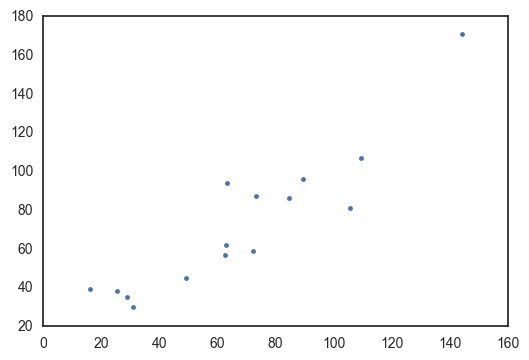

In [116]:
plt.plot(m,h,'.')
np.corrcoef(m,h)